## Analyzing RCT data with Precision Adjustment

In [2]:
using GLM, StatsModels
using DataTables
using DelimitedFiles, DataFrames, Lasso
using FilePaths
using StatsModels, Combinatorics
using CategoricalArrays
using StatsBase, Statistics
using TypedTables
using MacroTools
using NamedArrays
using PrettyTables # Dataframe or Datatable to latex
using TexTables # pretty regression table and tex outcome
using Plots

In [12]:
# Loading data

mat, head = readdlm("../../data/penn_jae.dat", header=true, Float64)
mat
df =DataFrame(mat, vec(head))
describe(df)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,abdt,10693.6,10404.0,10691.0,10880.0,0,Float64
2,tg,2.56889,0.0,2.0,6.0,0,Float64
3,inuidur1,12.9148,1.0,10.0,52.0,0,Float64
4,inuidur2,12.1938,0.0,9.0,52.0,0,Float64
5,female,0.402142,0.0,0.0,1.0,0,Float64
6,black,0.116653,0.0,0.0,1.0,0,Float64
7,hispanic,0.0363689,0.0,0.0,1.0,0,Float64
8,othrace,0.00575002,0.0,0.0,1.0,0,Float64
9,dep,0.444045,0.0,0.0,2.0,0,Float64


In [13]:
# Filter control group and just treatment group number 2

df = filter(row -> row[:tg] in [2,0], df)

first(df,20)

,abdt,tg,inuidur1,inuidur2,female,black,hispanic,othrace,dep
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,10824.0,0.0,18.0,18.0,0.0,0.0,0.0,0.0,2.0
2,10635.0,2.0,7.0,3.0,0.0,0.0,0.0,0.0,0.0
3,10824.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,10747.0,0.0,27.0,27.0,0.0,0.0,0.0,0.0,0.0
5,10754.0,2.0,20.0,20.0,1.0,0.0,0.0,0.0,0.0
6,10831.0,0.0,27.0,27.0,0.0,0.0,0.0,0.0,1.0
7,10845.0,0.0,27.0,27.0,1.0,0.0,0.0,0.0,0.0
8,10831.0,0.0,9.0,9.0,1.0,0.0,0.0,0.0,1.0
9,10859.0,0.0,27.0,27.0,1.0,0.0,0.0,0.0,1.0


In [14]:
# Treatment group n°4
replace!(df.tg, 2 => 1)
rename!(df, "tg" => "T2")


# from float to string
df[!,:dep] = string.(df[!,:dep]) 

# dep varaible in categorical format 
df[!,:dep] = categorical(df[!,:dep])

describe(df)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,abdt,10696.4,10404.0,10698.0,10880.0,0,Float64
2,T2,0.419924,0.0,0.0,1.0,0,Float64
3,inuidur1,13.0334,1.0,11.0,52.0,0,Float64
4,inuidur2,12.2511,0.0,10.0,52.0,0,Float64
5,female,0.400726,0.0,0.0,1.0,0,Float64
6,black,0.118817,0.0,0.0,1.0,0,Float64
7,hispanic,0.0363196,0.0,0.0,1.0,0,Float64
8,othrace,0.00518852,0.0,0.0,1.0,0,Float64
9,dep,,0.0,,2.0,0,"CategoricalValue{String, UInt32}"


In [53]:
Z = select(df, "inuidur1")
data_treat = filter(row -> row[:T2] in [1], df)
Z_treat  = select(data_treat, "inuidur1")
data_control = filter(row -> row[:T2] in [0], df)
Z_control  = select(data_control, "inuidur1")

means = DataFrame( DependentVar = names(Z), All = describe(Z, :mean)[!,2], Treat = describe(Z_treat,:mean)[!,2], Control = describe(Z_control,:mean)[!,2])

,DependentVar,All,Treat,Control
,String,Float64,Float64,Float64
1,inuidur1,13.0334,12.6129,13.3378


In [58]:
size(Z,1)

5782

In [59]:
size(Z_treat,1)

2428

In [60]:
size(Z_control,1)

3354

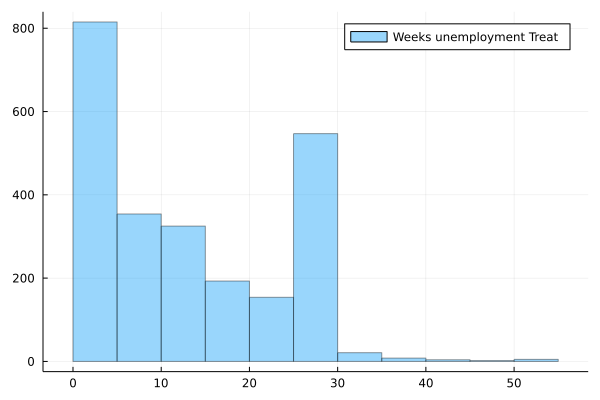

In [51]:

using Plots
gr()

pinta = map(!ismissing, data_treat.inuidur1)
histogram(data_treat.inuidur1[pinta], bins=10,alpha=0.4, label="Weeks unemployment Treat")
#histogram(data_control.inuidur1[pinta], bins=50, label="Weeks unemployment Treat")

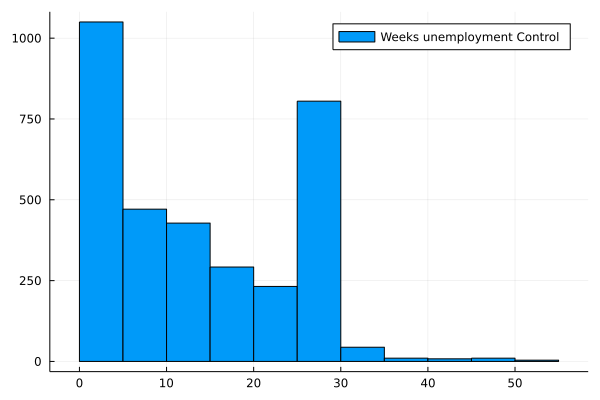

In [52]:
using Plots
gr()

pinta = map(!ismissing, data_control.inuidur1)
histogram(data_control.inuidur1[pinta], alpha=1, bins=20, label="Weeks unemployment Control")

We can see that the distributions of the two groups are similar in shape. They have quite unusual observations that go up to 50+ weeks unemployed. However, in the control group, there are more people who delay in finding a job.

#### BALANCE CHECK

In [79]:
first(df,20)

,abdt,T2,inuidur1,inuidur2,female,black,hispanic,othrace,dep
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Cat…
1,10824.0,0.0,18.0,18.0,0.0,0.0,0.0,0.0,2.0
2,10635.0,1.0,7.0,3.0,0.0,0.0,0.0,0.0,0.0
3,10824.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,10747.0,0.0,27.0,27.0,0.0,0.0,0.0,0.0,0.0
5,10754.0,1.0,20.0,20.0,1.0,0.0,0.0,0.0,0.0
6,10831.0,0.0,27.0,27.0,0.0,0.0,0.0,0.0,1.0
7,10845.0,0.0,27.0,27.0,1.0,0.0,0.0,0.0,0.0
8,10831.0,0.0,9.0,9.0,1.0,0.0,0.0,0.0,1.0
9,10859.0,0.0,27.0,27.0,1.0,0.0,0.0,0.0,1.0


In [63]:
    # couples variables combinations 
    combinations_upto(x, n) = Iterators.flatten(combinations(x, i) for i in 1:n)

    # combinations without same couple
    expand_exp(args, deg::ConstantTerm) =
        tuple(((&)(terms...) for terms in combinations_upto(args, deg.n))...)

    StatsModels.apply_schema(t::FunctionTerm{typeof(^)}, sch::StatsModels.Schema, ctx::Type) =
        apply_schema.(expand_exp(t.args_parsed...), Ref(sch), ctx)

In [65]:
# OLS 
reg1 = @formula(T2 ~ (female+black+othrace+dep+q2+q3+q4+q5+q6+agelt35+agegt54+durable+lusd+husd)^2)
reg1 = apply_schema(reg1, schema(reg1, df))

FormulaTerm
Response:
  T2(continuous)
Predictors:
  female(continuous)
  black(continuous)
  othrace(continuous)
  dep(DummyCoding:3→2)
  q2(continuous)
  q3(continuous)
  q4(continuous)
  q5(continuous)
  q6(continuous)
  agelt35(continuous)
  agegt54(continuous)
  durable(continuous)
  lusd(continuous)
  husd(continuous)
  female(continuous) & black(continuous)
  female(continuous) & othrace(continuous)
  female(continuous) & dep(DummyCoding:3→2)
  female(continuous) & q2(continuous)
  female(continuous) & q3(continuous)
  female(continuous) & q4(continuous)
  female(continuous) & q5(continuous)
  female(continuous) & q6(continuous)
  female(continuous) & agelt35(continuous)
  female(continuous) & agegt54(continuous)
  female(continuous) & durable(continuous)
  female(continuous) & lusd(continuous)
  female(continuous) & husd(continuous)
  black(continuous) & othrace(continuous)
  black(continuous) & dep(DummyCoding:3→2)
  black(continuous) & q2(continuous)
  black(continuous) & q3(

In [68]:
m1 = lm(reg1, df)
table = regtable( "Covariate Balance Check" => m1) # coeficientes, standar error, squared R, N (sample size )

                   | Covariate Balance Check 
                   |           (1)           
---------------------------------------------
       (Intercept) |                0.517*** 
                   |                 (0.158) 
            female |                   0.006 
                   |                 (0.130) 
             black |                  0.100* 
                   |                 (0.060) 
           othrace |                 -0.829* 
                   |                 (0.471) 
          dep: 1.0 |                   0.158 
                   |                 (0.186) 
          dep: 2.0 |                  -0.193 
                   |                 (0.163) 
                q2 |                  -0.109 
                   |                 (0.159) 
                q3 |                  -0.108 
                   |                 (0.159) 
                q4 |                  -0.062 
                   |                 (0.159) 
                q5 |              

In [69]:
m1

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

T2 ~ 1 + female + black + othrace + dep + q2 + q3 + q4 + q5 + q6 + agelt35 + agegt54 + durable + lusd + husd + female & black + female & othrace + female & dep + female & q2 + female & q3 + female & q4 + female & q5 + female & q6 + female & agelt35 + female & agegt54 + female & durable + female & lusd + female & husd + black & othrace + black & dep + black & q2 + black & q3 + black & q4 + black & q5 + black & q6 + black & agelt35 + black & agegt54 + black & durable + black & lusd + black & husd + othrace & dep + othrace & q2 + othrace & q3 + othrace & q4 + othrace & q5 + othrace & q6 + othrace & agelt35 + othrace & agegt54 + othrace & durable + othrace & lusd + othrace & husd + dep & q2 + dep & q3 + dep & q4 + dep & q5 + dep & q6 + dep & agelt35 + dep & agegt54 + dep & durable + dep & lusd + dep & husd + q2 & q

The randomization is well done because the estimators of the previous regression are not significant, or are very close to zero. That is, the control and treatment group have similar characteristics and are comparable.

#### MODEL SPECIFICATION

##### Classical 2-sample approach, no adjustment (CL)

In [89]:
ols_cl = lm(@formula(log(inuidur1) ~ T2), df)

table1 = regtable( "No adjustment model" => ols_cl)

            | No adjustment model 
            |         (1)         
----------------------------------
(Intercept) |            2.057*** 
            |             (0.021) 
         T2 |            -0.079** 
            |             (0.032) 
----------------------------------
          N |                5782 
      $R^2$ |               0.001 


In [ ]:
# The treatment group takes an average of 8% fewer weeks to get a job than the control group
# Treatment group reduces unemployed weeks by 7,9% compared to control group

##### Classical linear regression adjustment (CRA)

In [130]:
reg2 = @formula(log(inuidur1) ~ T2 + (female+black+othrace+dep+q2+q3+q4+q5+q6+agelt35+agegt54+durable+lusd+husd)^2)
reg2 = apply_schema(reg2, schema(reg2, df))

ols_cra = lm(reg2, df)
table2 = regtable("CRA model" => ols_cra)
size(table2)

(123, 1)

In [ ]:
# Treatment group reduces unemployed weeks by 7,1% compared to control group

##### Interactive regression adjustment (IRA)

In [87]:
# demean function
function desv_mean(a)
    A = mean(a, dims = 1)
    M = zeros(Float64, size(X,1), size(X,2))
    for i in 1:size(a,2)
          M[:,i] = a[:,i] .- A[i]
    end
    return M
end    

# Matrix Model & demean
X = StatsModels.modelmatrix(reg1.rhs,df)
X = desv_mean(X) # matrix format 
 

5782×119 Matrix{Float64}:
 -0.400726  -0.118817  -0.00518852  -0.116569  …  -0.0549983  -0.0290557  0.0
 -0.400726  -0.118817  -0.00518852  -0.116569     -0.0549983  -0.0290557  0.0
 -0.400726  -0.118817  -0.00518852  -0.116569     -0.0549983  -0.0290557  0.0
 -0.400726  -0.118817  -0.00518852  -0.116569     -0.0549983  -0.0290557  0.0
  0.599274  -0.118817  -0.00518852  -0.116569     -0.0549983  -0.0290557  0.0
 -0.400726  -0.118817  -0.00518852   0.883431  …   0.945002   -0.0290557  0.0
  0.599274  -0.118817  -0.00518852  -0.116569     -0.0549983  -0.0290557  0.0
  0.599274  -0.118817  -0.00518852   0.883431     -0.0549983  -0.0290557  0.0
  0.599274  -0.118817  -0.00518852   0.883431     -0.0549983  -0.0290557  0.0
 -0.400726  -0.118817  -0.00518852  -0.116569     -0.0549983  -0.0290557  0.0
  0.599274  -0.118817  -0.00518852  -0.116569  …  -0.0549983  -0.0290557  0.0
  0.599274  -0.118817  -0.00518852  -0.116569     -0.0549983  -0.0290557  0.0
  0.599274  -0.118817  -0.00518852  -0

In [88]:
Y = select(df, [:inuidur1,:T2]) # select inuidur1 y T2

X = DataFrame(hcat(X, Matrix(select(df, [:T2])).*X), :auto)  # Joint X, (T2*X)

base = hcat(Y, X) # Joint inuidur1, T2, X y (T2*X)

base.inuidur1 = log.(base.inuidur1)  # log(inuidur1)

terms = term.(names(base)) # term.() let us to get all variables as objects

#interactive regression model

ols_ira  = lm(terms[1] ~ sum(terms[2:end]), base)

table3 = regtable("Interactive model" => ols_ira)

#terms[1] # select first variable. In this case, oucome of interest 
#sum(terms[2:end]) # independent variables as regresors in the linear regression   

# En terminos absolutos aumento el efecto del tratamiento (7,2%), pero no es una diferencia tan grande en comparación a los otros modelos

            | Interactive model 
            |        (1)        
--------------------------------
(Intercept) |          2.057*** 
            |           (0.021) 
         T2 |          -0.072** 
            |           (0.032) 
         x1 |            -0.666 
            |           (0.445) 
         x2 |         -0.863*** 
            |           (0.270) 
         x3 |            -1.735 
            |           (2.173) 
         x4 |             0.036 
            |           (0.685) 
         x5 |             0.212 
            |           (0.497) 
         x6 |             0.000 
            |             (NaN) 
         x7 |          -0.367** 
            |           (0.150) 
         x8 |            -0.225 
            |           (0.154) 
         x9 |            -0.117 
            |           (0.149) 
        x10 |           -0.422* 
            |           (0.225) 
        x11 |            -0.678 
            |           (0.435) 
        x12 |            -0.304 
          

##### Interactive regression adjustment (IRA) using Lasso

In [94]:
X = StatsModels.modelmatrix(reg2.rhs,df)
X = desv_mean(X)


D = DataFrame([X[:,1]], :auto)  # Treatment varaible

rename!(D, Dict(:x1 => :T2)) #rename x1 -> T2

X = DataFrame(hcat(X[:,2:end], X[:,1].*X[:,2:end]), :auto)  # Join Controls (X) + T4*X "interactive"

Y = select(penn, [:inuidur1]) #select just inuidur1

Y.inuidur1 = log.(Y.inuidur1)  # log(inuidur1)


5782-element Vector{Float64}:
 2.8903717578961645
 1.9459101490553132
 0.0
 3.295836866004329
 2.995732273553991
 3.295836866004329
 3.295836866004329
 2.1972245773362196
 3.295836866004329
 3.295836866004329
 2.70805020110221
 1.0986122886681098
 3.332204510175204
 ⋮
 2.302585092994046
 2.995732273553991
 3.295836866004329
 3.295836866004329
 2.70805020110221
 0.0
 3.1354942159291497
 1.791759469228055
 2.6390573296152584
 2.1972245773362196
 1.3862943611198906
 3.295836866004329

###### Using HDML

In [110]:
#using Pkg
#Pkg.add("TableOperations")
Pkg.add("FreqTables")
using TableOperations

   Resolving package versions...
   Installed FreqTables ─ v0.4.5
    Updating `C:\Users\Andrea\.julia\environments\v1.6\Project.toml`
  [da1fdf0e] + FreqTables v0.4.5
    Updating `C:\Users\Andrea\.julia\environments\v1.6\Manifest.toml`
  [da1fdf0e] + FreqTables v0.4.5
Precompiling project...
  ✓ FreqTables
  ✓ CSV
  ✓ DataFrames
  ✓ GLMNet
  ✓ RData
  ✓ TexTables
  ✓ Lathe
  ✓ Plots
  ✓ StatsPlots
  9 dependencies successfully precompiled in 40 seconds (224 already precompiled, 4 skipped during auto due to previous errors)
  4 dependencies precompiled but different versions are currently loaded. Restart julia to access the new versions


In [111]:
include("C:\\Users\\Andrea\\Documentos\\GitHub\\ECO224\\Labs\\Julia_Notebooks\\hdmjl\\hdmjl.jl")

In [112]:
lm(Matrix(X), vec(Matrix(D)))

LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}}}}:

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────────────────
                Coef.     Std. Error                 t  Pr(>|t|)        Lower 95%        Upper 95%
──────────────────────────────────────────────────────────────────────────────────────────────────
x1        1.8245e-12     6.57133e-12              0.28    0.7813     -1.10579e-11      1.47069e-11
x2       -8.06968e-13    4.39524e-12             -0.18    0.8543     -9.42335e-12      7.80942e-12
x3     -194.425          7.94261e-10  -244787126120.56    <1e-99   -194.425         -194.425
x4       -5.38571e-12    9.84614e-12             -0.55    0.5844     -2.4688e-11       1.39166e-11
x5       -7.64799e-12    8.48967e-12             -0.90    0.3677     -2.4291e-11       8.99507e-12
x6        0.0          NaN                      NaN       NaN       NaN              N

In [113]:
D_reg_0  = rlasso_arg( X, D, nothing, true, true, true, false, false, 
                    nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )

rlasso_arg(5782×238 DataFrame
  Row │ x1         x2         x3           x4         x5         x6         x7 ⋯
      │ Float64    Float64    Float64      Float64    Float64    Float64    Fl ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ -0.400726  -0.118817  -0.00518852  -0.116569   0.839329  -0.200104  -0 ⋯
    2 │ -0.400726  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104   0
    3 │ -0.400726  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104  -0
    4 │ -0.400726  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104  -0
    5 │  0.599274  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104  -0 ⋯
    6 │ -0.400726  -0.118817  -0.00518852   0.883431  -0.160671  -0.200104  -0
    7 │  0.599274  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104  -0
    8 │  0.599274  -0.118817  -0.00518852   0.883431  -0.160671  -0.200104  -0
    9 │  0.599274  -0.118817  -0.00518852   0.883431  -0.160671  -0.200104  -0 ⋯
   10 │ -0

In [114]:
D_resid = rlasso(D_reg_0)["residuals"]

5782-element Vector{Float64}:
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555
  ⋮
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555

In [115]:
Y_reg_0  = rlasso_arg( X, Y, nothing, true, true, true, false, false, 
                    nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )


rlasso_arg(5782×238 DataFrame
  Row │ x1         x2         x3           x4         x5         x6         x7 ⋯
      │ Float64    Float64    Float64      Float64    Float64    Float64    Fl ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ -0.400726  -0.118817  -0.00518852  -0.116569   0.839329  -0.200104  -0 ⋯
    2 │ -0.400726  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104   0
    3 │ -0.400726  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104  -0
    4 │ -0.400726  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104  -0
    5 │  0.599274  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104  -0 ⋯
    6 │ -0.400726  -0.118817  -0.00518852   0.883431  -0.160671  -0.200104  -0
    7 │  0.599274  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104  -0
    8 │  0.599274  -0.118817  -0.00518852   0.883431  -0.160671  -0.200104  -0
    9 │  0.599274  -0.118817  -0.00518852   0.883431  -0.160671  -0.200104  -0 ⋯
   10 │ -0

In [118]:
Y_resid = rlasso(Y_reg_0)["residuals"]

5782-element Vector{Float64}:
  0.7317507898950125
 -0.053847340538496935
 -2.158620968001152
  1.1372158980031772
  0.8371113055528389
  0.9765378557198109
  0.9765378557198109
 -0.12207443294829867
  1.1372158980031772
  1.1372158980031772
  0.5494292331010581
 -1.060008679333042
  1.0129054998906857
  ⋮
  0.30282760340023573
  0.9959747839601807
  1.296079376410519
  1.1372158980031772
  0.886137646436093
 -1.9997574895938102
  1.3218668945897833
 -0.36686149877309704
  0.8254300082758922
  0.1974670877424094
 -0.9330046491646277
  0.9765378557198109

In [119]:
D_resid = reshape(D_resid, length(D_resid), 1)

5782×1 Matrix{Float64}:
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555
  ⋮
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555

In [121]:
Lasso_ira = lm(D_resid, Y_resid)

LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}}}}:

Coefficients:
──────────────────────────────────────────────────────────────────
         Coef.  Std. Error      t  Pr(>|t|)  Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────
x1  -0.0745733   0.0320861  -2.32    0.0202  -0.137474  -0.0116724
──────────────────────────────────────────────────────────────────


In absolute terms, the treatment effect increased (7.4%), but it is not such a big difference compared to the other models

##### JOIN ALL THE MODELS AT TABLE

In [122]:
table = NamedArray(zeros(4, 5))

4×5 Named Matrix{Float64}
A ╲ B │   1    2    3    4    5
──────┼────────────────────────
1     │ 0.0  0.0  0.0  0.0  0.0
2     │ 0.0  0.0  0.0  0.0  0.0
3     │ 0.0  0.0  0.0  0.0  0.0
4     │ 0.0  0.0  0.0  0.0  0.0

In [129]:
table = NamedArray(zeros(4, 5))

table[1,2] = GLM.coeftable(ols_cl).cols[1][2]
table[2,2] = GLM.coeftable(ols_cl).cols[2][2]
table[3,2] = GLM.coeftable(ols_cl).cols[5][2]
table[4,2] = GLM.coeftable(ols_cl).cols[6][2]
table[1,3] = GLM.coeftable(ols_cra).cols[1][2]
table[2,3] = GLM.coeftable(ols_cra).cols[2][2]
table[3,3] = GLM.coeftable(ols_cra).cols[5][2]
table[4,3] = GLM.coeftable(ols_cra).cols[6][2]
table[1,4] = GLM.coeftable(ols_ira).cols[1][2]
table[2,4] = GLM.coeftable(ols_ira).cols[2][2]
table[3,4] = GLM.coeftable(ols_ira).cols[5][2]
table[4,4] = GLM.coeftable(ols_ira).cols[6][2]
table[1,5] = GLM.coeftable(Lasso_ira).cols[1][1]
table[2,5] = GLM.coeftable(Lasso_ira).cols[2][1]
table[3,5] = GLM.coeftable(Lasso_ira).cols[5][1]
table[4,5] = GLM.coeftable(Lasso_ira).cols[6][1]

T = DataFrame(table, [ :"Outcome", :"CL", :"CRA", :"IRA", :"IRA W Lasso"])  # table to dataframe 
T[!,:Outcome] = string.(T[!,:Outcome])  # string - first column 

T[1,1] = "Estimation"
T[2,1] = "Standar error"
T[3,1] = "Lower bound CI"
T[4,1] = "Upper bound CI"

T
#header = (["Outcome", "CL", "CRA", "IRA", "IRA W Lasso"])

#pretty_table(T; backend = Val(:latex), header = header, formatters=ft_round(4), alignment=:c)

#Val(:latex) to tex format (Dataframe or DataTable, table , etc)

#pretty_table(T; backend = Val(:latex), header = header, formatters=ft_round(4), alignment=:c)

,Outcome,CL,CRA,IRA,IRA W Lasso
,String,Float64,Float64,Float64,Float64
1,Estimation,-0.0788253,-0.0712066,-0.072397,-0.0745733
2,Standar error,0.0324613,0.0320886,0.0322618,0.0320861
3,Lower bound CI,-0.142462,-0.134112,-0.135643,-0.137474
4,Upper bound CI,-0.0151891,-0.0083008,-0.00915134,-0.0116724


#### PLOT THE COEFFICIENTS OF THE T2*female, T2*black, T2*agelt35, T2*factor(dep)1

I am assuming that from X125 the interactions of T with the other covariates begin. So:
- T2*female es X125
- T2*black es X126
- T2*factor(dep)1 es X127
- T2*agelt35 es X134

In [132]:
# Extract the coefficients from the equation ols_ira


#Extrayendo los coeficientes y errores estándar. Esto debe corregirse, lo traté de hacer manualmente, viendo la posición de cada
#variable dentro de los 240 regresores, pero con la extensión del paquete que mostró Roberto hoy los nombres de las variables ya
#se deberían mostrar automáticamente.
T2_female = coef(ols_ira)[125]
T2_black = coef(ols_ira)[126]
T2_dep1 = coef(ols_ira)[128]
T2_agelt35 = coef(ols_ira)[134]


0.06985501900805365

In [134]:
coeff = [T2_female,T2_black,T2_dep1,T2_agelt35]
labels = ["T2*Female","T2*Black", "T2*factor(dep)1","T2*agelt35"]

4-element Vector{String}:
 "T2*Female"
 "T2*Black"
 "T2*factor(dep)1"
 "T2*agelt35"

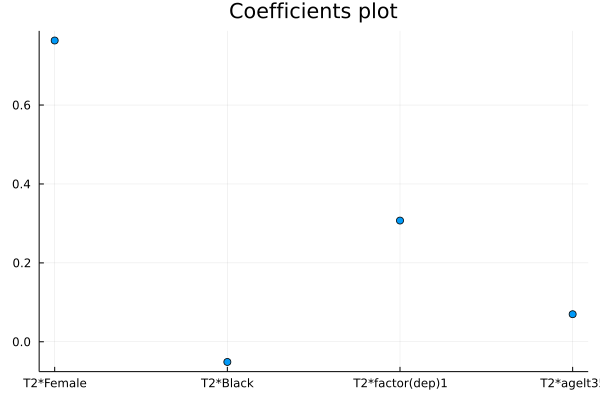

In [137]:
Plots.scatter(labels, coeff, legend = false, title = "Coefficients plot")

Each one of these coefficients is indicating the effect of the treatment in characteristic groups. For example, T2female means treatment persons who are female. We can see that the effect of all except the Black people treatment group is positive. The positive effect means that the treatment of incentivizing money to reduce weeks of unemployment is not being fulfilled in the case of women, dep1 or agelt3.
In contrast, for the group of black people who were given the treatment, it is managing to reduce the number of weeks of unemployment a little compared to the control group.

## Analyzing RCT: Polio and Pfizer/BNTX Covid-19 RCT

### POLIO RCT

The question was whether Salk vaccine prevented polio. Children in the study were randomly assigned either a treatment (polio vaccine shot) or a placebo (saline solution shot), without knowing which one they received. The doctors in the study, making the diagnosis, did not know whether a child received a vaccine or not. In other words, the trial was a double-blind, randomized control trial. The trial had to be large, because the rate at which Polio occured in the population was 50 per 100,000. The treatment group saw 33 polio cases per 200,745; the control group saw 115 cases per 201,229. The estimated avearage treatment effect is about -40, with the 95% confidence band (based on approximate normality of the two sample means and their differences): [−52,−28].

As this is an RCT, the confidence band suggests that the Polio vaccine caused the reduction in the risk of polio.

The interesting thing here is that we don't need the underlying individual data to evaluate the effectivess of the vaccine. This is because the outcomes are Bernoulli random variables, and we have enough information to compute the estimate of ATE as well as the confidence intervals from the group case counts.

We also compute the Vaccine Efficacy metric, which refers to the following measure according to the CDC: 


\begin{align}
VE = \frac{Risk for Unvaccinated - Risk for Vaccinated}{Risk for Unvaccinated}
\end{align}

It describes the relative reduction in risk caused by vaccination.

It is staightforward to get the VE estimate by just plugging-in the numbers, but how do we get the approximate variance estimate? I am too lazy to do calculations for the delta method, so I will just use a simulation (a form of approximate bootstrap) to obtain the confidence intervals.

In [138]:
NT = 200745 #number of treated

NC = 201229 #number of controlled

YT = 33/NT  #average outcome for treated

YC = 115/NC  #average outcome for controlled

#incidence per 100000 

println("Incidence per 100000 among treated: ", YT*100000, "\n","Incidence per 100000 among controlled: ", YC*100000 )

Incidence per 100000 among treated: 16.438765598146905
Incidence per 100000 among controlled: 57.14882049803955


In [141]:
# treatment effect estimate reduction in incidence  per 100000 people

delta_hat = 100000*(YT-YC)
println("Estimate TE of occurances per 100,000: ",100000*(YT-YC))


Estimate TE of occurances per 100,000: -40.71005489989265


In [153]:
Var_delta_hat =  (100000^2)*(YT*(1-YT)/NT +  YC*(1-YC)/NC)

# standard deviation

println("Standard deviation for ATE ", Var_delta_hat^.5)

# here we are using the fact that outcomes are Bernoulli 

CI_delta = [delta_hat -1.96*Var_delta_hat^.5 + delta_hat +1.96*Var_delta_hat^.5]
CI_delta
println("95 % confidence interval is [", CI_delta[1], ",", CI_delta[2], "]") 

Standard deviation for ATE 6.047412320702958
95 % confidence interval is [-40.71005489989265,-52.56298304847044]


In [167]:
# Here we calculate the overall effectiveness of the vaccine and construct confidence intervals for it

NV =  200745;
NU =  201229;
RV = 33/NV;
RU = 115/NU;
VE = (RU - RV)/RU;
print("Overall VE is ", VE)

Overall VE is 0.7123516206478694

In [186]:
# this recovers the number in the table.

# we set up a simulation example.

# calulate variance of risk estimates:

Var_RV = RV*(1-RV)/NV
Var_RU = RU*(1-RU)/NU



# set-up MC draws:

B = 10000
RVs = RV  .+ randn(B)*(Var_RV)^.5
RUs = RU  .+ randn(B)*Var_RU^.5
VEs= (RUs .- RVs)./RUs


CI_VE_L = quantile!(VEs, .025)
CI_VE_U = quantile!(VEs, .975)

println("95 % confidence interval is [", CI_VE_L, ",", CI_VE_U, "]")

95 % confidence interval is [0.5884755941099193,0.8174573705792546]


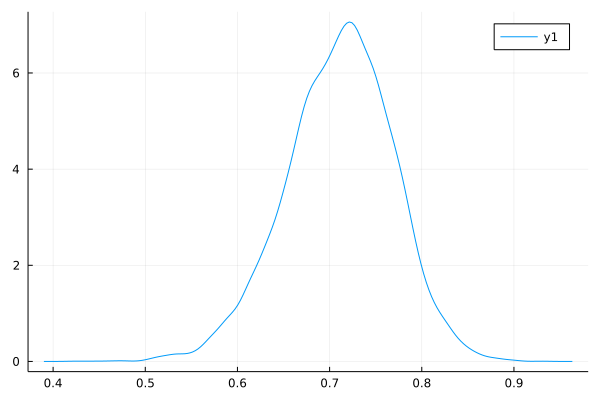

In [190]:
# instantiate and fit the KDE model

using StatsPlots
pinta = map(!ismissing, VEs)
density(VEs[pinta])